# Training a Model

The following notebook outlines how to train a binary model in the cohesive vs. non-cohesive case (which with a few modifications can be changed to the non-free flowing vs. free flowing or the multiclass case).

The first thing to do is to import the relevant libraries.

In [1]:
%matplotlib notebook
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("..")
from data_prep import training_data_prep
from model import vgg11
from training import BinaryTrainer

/home/gwb21218/miniconda3/envs/dm2/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/gwb21218/miniconda3/envs/dm2/lib/python3.8/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn(


Next the path to the images and the class labels are defined.

In [2]:
image_path = "../20220929_dataset_all_classes/"
labels_path = "../20220929_dataset_all_classes/FFc_data_with_G3descs.txt"

Now we use the `training_data_prep` function to segment and augment the dataset and return the training and validation data along with their ground truth labels. This function takes inputs:

* `imgs_pth` &mdash; the path to the images, in this case `image_path`
* `class_pth` &mdash; the path to the file containing the class labels, in this case `labels_path`
* `model_classes` &mdash; which model is being trained to tell the code which numerical label to assign to each image, here is `"cohesive"` which is the cohesive vs. non-cohesive model

This function reads in all the images and augments them will a vertical and horizontal mirroring before splitting them up into 1024$\times$1024 segments which are used for the training and validation.

The outputs are:

* `trainval_images` &mdash; the training and validation datasets augmented and segmented
* `trainval_labels` &mdash; the training and validation datasets' labels for classification

In [3]:
trainval_images, trainval_labels = training_data_prep(image_path, labels_path, model_classes="cohesive")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 270/270 [16:56<00:00,  3.77s/it]


Now the data must be split into training and validation datasets. This is down by randomly shuffling the order of the images and then taking the first 90% to be the training dataset and the final 10% to be the validation dataset.

In [4]:
indices = np.arange(trainval_labels.shape[0])
np.random.RandomState(seed=12).shuffle(indices)
max_idx = int(0.9*indices.shape[0])

train_in = torch.from_numpy(trainval_images[indices[:max_idx]]).unsqueeze(1)
train_out = torch.from_numpy(trainval_labels[indices[:max_idx]])
val_in = torch.from_numpy(trainval_images[indices[max_idx:]]).unsqueeze(1)
val_out = torch.from_numpy(trainval_labels[indices[max_idx:]])

Next the model, optimiser, learning rate scheduler and loss function are defined. In this example, we are training a binary model using stochastic gradient descent (SGD) with momentum as the optimiser with the learning rate reduced by a factor of 10 when the validation loss does not decrease for 2 epochs.

The loss function used is the binary cross entropy (BCE) loss which measures the similarity between the estimated probability that an image belongs to class 1 and the class label itself. Since the dataset is set up to have approximately equal samples in each of the three clases, when training a binary model there will be a class imbalance e.g. for the cohesive vs. non-cohesive model here, the non-cohesive class contains both easy flowing and free flowing materials so the number of datapoints in the non-cohesive class is about 2$\times$ the number of datapoints in the cohesive class. To account for this we set the `pos_weight` argument in the loss function which is the ratio of the number of datapoints in class 0 to the number of datapoints in class 1. This value multiplies the loss to alleviate the class imbalance (specifically, in this case, the class 1 samples have less of an effect on the direction of the optimiser since there are more).

In [5]:
vgg = vgg11(model_type="binary")

In [6]:
optimi = optim.SGD(vgg.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
sched = optim.lr_scheduler.ReduceLROnPlateau(optimi, factor=0.1, patience=2, verbose=True)

In [7]:
_, counts = np.unique(train_out, return_counts=True)

In [8]:
pos_weight = torch.tensor(counts[0]/counts[1]).to("cuda:0")
loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

Finally, a `Trainer` must be defined. This is an object which contains the methods for training and validating the model along with the visualisation of the training. For this we need the inputs:

* `model` &mdash; the model to train
* `optimiser` &mdash; the optimiser to use
* `loss_fn` &mdash; the loss function to use
* `no_of_epochs` &mdash; the number of epochs to train for
* `batch_size` &mdash; the batch size to use during training and validation
* `data_pth` &mdash; this is an optional argument depending on how the `load_data` class method is set up, here we load the data before adding it to the trainer so the value of `data_pth` is `None`.
* `save_dir` &mdash; the directory to save the models to
* `device_id` &mdash; the device to perform the training and validation on, here we use 0 so the device used with be labelled `"cuda:0"`
* `data_parallel` &mdash; whether or not to train and validate on multiple GPUs.

Then we use the `load_data` class method to put the training and validation data to the trainer. Then the network is trained and validated.

In [9]:
trainer = BinaryTrainer(
    model = vgg, optimiser = optimi, loss_fn = loss_fn, no_of_epochs=50, batch_size=24, data_pth=None, save_dir="vgg11_co_230123/", scheduler=sched, device_id=0
)

In [10]:
trainer.load_data(train_in, train_out, val_in, val_out)

<IPython.core.display.Javascript object>


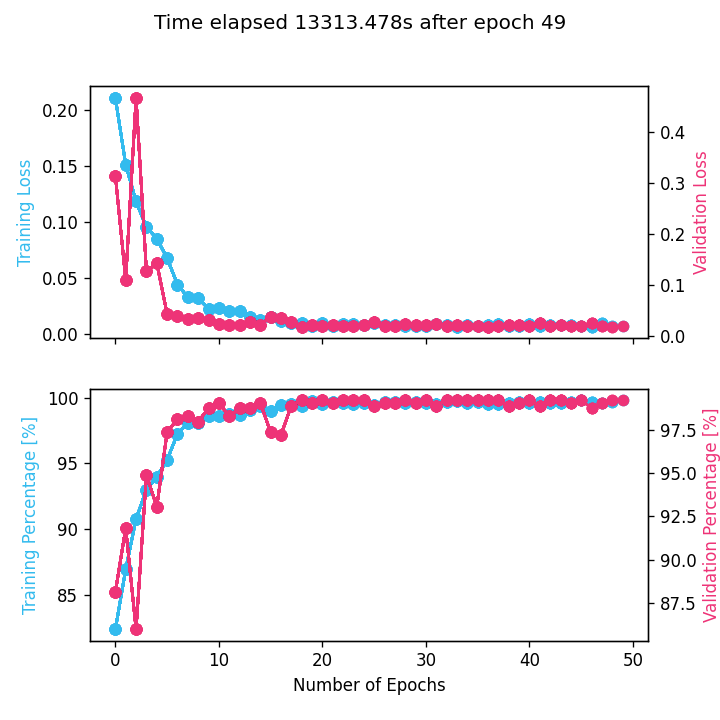

  0%|                                                                                                                                                                                      | 0/243 [00:00<?, ?it/s]/home/gwb21218/miniconda3/envs/dm2/lib/python3.8/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [04:15<00:00,  1.05s/it]


Epoch 00005: reducing learning rate of group 0 to 1.0000e-03.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [04:15<00:00,  1.05s/it]


Epoch 00018: reducing learning rate of group 0 to 1.0000e-04.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [04:15<00:00,  1.05s/it]


Epoch 00022: reducing learning rate of group 0 to 1.0000e-05.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [04:15<00:00,  1.05s/it]


Epoch 00025: reducing learning rate of group 0 to 1.0000e-06.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [04:15<00:00,  1.05s/it]


Epoch 00028: reducing learning rate of group 0 to 1.0000e-07.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [04:15<00:00,  1.05s/it]


Epoch 00031: reducing learning rate of group 0 to 1.0000e-08.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [04:15<00:00,  1.05s/it]


In [11]:
trainer.shady_guy()